In [10]:
# pip install xgboost
# pip install lightgbm
# pip install catboost
# pip install imbalanced-learn

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import label_binarize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

from xgboost import XGBRegressor
from xgboost import XGBClassifier

from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier

from catboost import CatBoostRegressor
from catboost import CatBoostClassifier

from sklearn.compose import ColumnTransformer

#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

In [12]:
train_df = pd.read_csv('dados/train.csv')
test_df = pd.read_csv('dados/test.csv')

In [13]:
# Exploratory analysis
df = train_df.copy()

df['Basic_Demos-Age_Zone'] = pd.cut(df['Basic_Demos-Age'], 
                                        bins=[0, 13, 18, 41, 66], 
                                        labels=['criança', 'adolescente', 'adulto', 'idoso'])

In [14]:
num_registros, num_colunas = df.shape

print(f"Quantidade de registros: {num_registros}")
print(f"Quantidade de colunas: {num_colunas}")

Quantidade de registros: 3960
Quantidade de colunas: 83


In [15]:
def listar_correlacoes(df, campo_analise, threshold=0.5):
    # Calcular a matriz de correlação
    correlacoes = df.corr()
    
    # Selecionar as correlações da coluna de interesse e aplicar o threshold
    correlacao_alvo = correlacoes[campo_analise]
    correlacao_filtrada = correlacao_alvo[abs(correlacao_alvo) > threshold]
    
    # Remover a autocorrelação da própria coluna
    correlacao_filtrada = correlacao_filtrada.drop(index=campo_analise)
    
    # Ordenar as correlações em ordem decrescente de valor absoluto
    correlacao_ordenada = correlacao_filtrada.abs().sort_values(ascending=False)
    
    # Exibir o resultado
    print(f"Colunas com correlação maior que {threshold} com '{campo_analise}':")
    for coluna, valor in correlacao_ordenada.items():
        print(f"{coluna}: {valor:.3f}")

df_temp = df[df.select_dtypes(include=['number']).columns.tolist()]
listar_correlacoes(df_temp, 'sii', threshold=0.7)

Colunas com correlação maior que 0.7 com 'sii':
PCIAT-PCIAT_Total: 0.900
PCIAT-PCIAT_15: 0.751
PCIAT-PCIAT_18: 0.731
PCIAT-PCIAT_17: 0.730
PCIAT-PCIAT_05: 0.723
PCIAT-PCIAT_13: 0.706
PCIAT-PCIAT_20: 0.703


In [16]:
def analysis_pipeline(df1, df2, x, y, z):      
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    
    # Identificar possíveis outliers usando um scatter plot no primeiro subplot
    scatter1 = axes[0].scatter(df1[x], df1[y], c=df1[z], cmap='viridis', s=50)
    fig.colorbar(scatter1, ax=axes[0], label=z)
    axes[0].set_title('DF Original')
    axes[0].set_xlabel(x)
    axes[0].set_ylabel(y)
    
    # Scatter plot no segundo subplot
    scatter2 = axes[1].scatter(df2[x], df2[y], c=df2[z], cmap='viridis', s=50)
    fig.colorbar(scatter2, ax=axes[1], label=z)
    axes[1].set_title('DF com valores previstos')
    axes[1].set_xlabel(x)
    axes[1].set_ylabel(y)

    plt.tight_layout()
    plt.show()

In [17]:
def statistical_analysis(df, coluna):
    stats = df[coluna].describe()

    # Calcular quantidade de nulos e percentual
    missing_count = df[coluna].isnull().sum()
    missing_percent = (missing_count / len(df)) * 100

    # Adicionar informações de nulos ao DataFrame de estatísticas descritivas
    stats['Valores Nulos'] = missing_count
    stats['Percentual Nulos (%)'] = missing_percent
    
    # Calcular a correlação entre idade e sii
    correlation = df[coluna].corr(df['sii'])
    stats['Correlação (sii)'] = correlation
    print(f'Analise estatística da coluna {coluna}')
    print(stats)

statistical_analysis(df, 'sii')

Analise estatística da coluna sii
count                   2736.000000
mean                       0.580409
std                        0.771122
min                        0.000000
25%                        0.000000
50%                        0.000000
75%                        1.000000
max                        3.000000
Valores Nulos           1224.000000
Percentual Nulos (%)      30.909091
Correlação (sii)           1.000000
Name: sii, dtype: float64


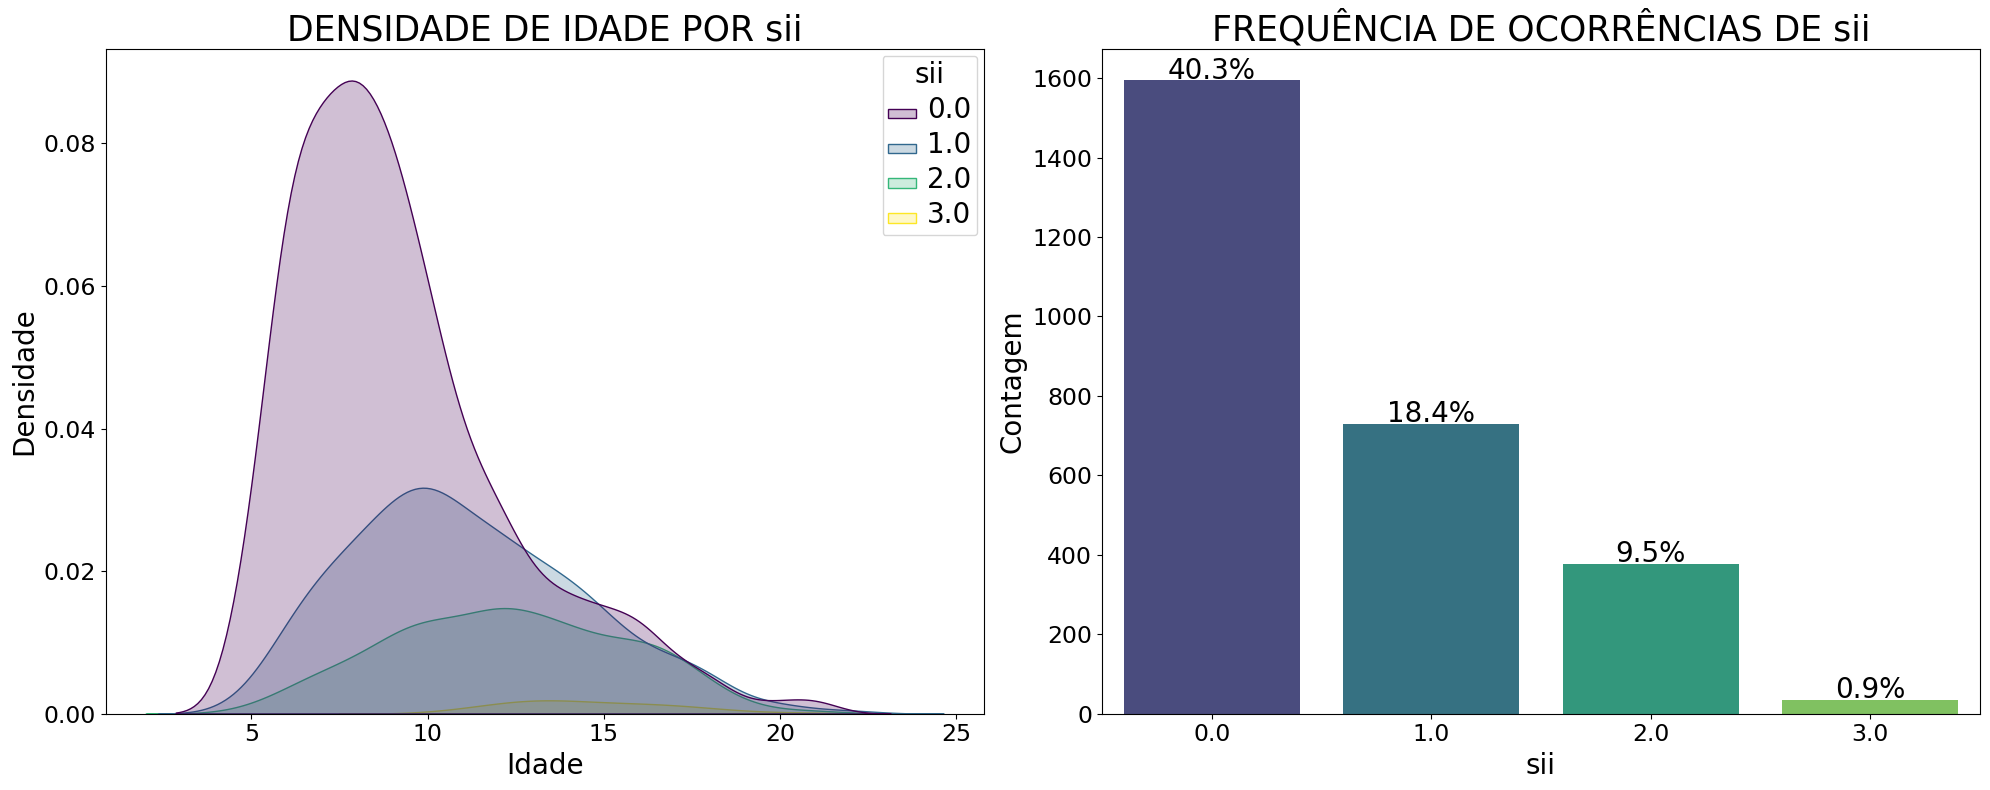

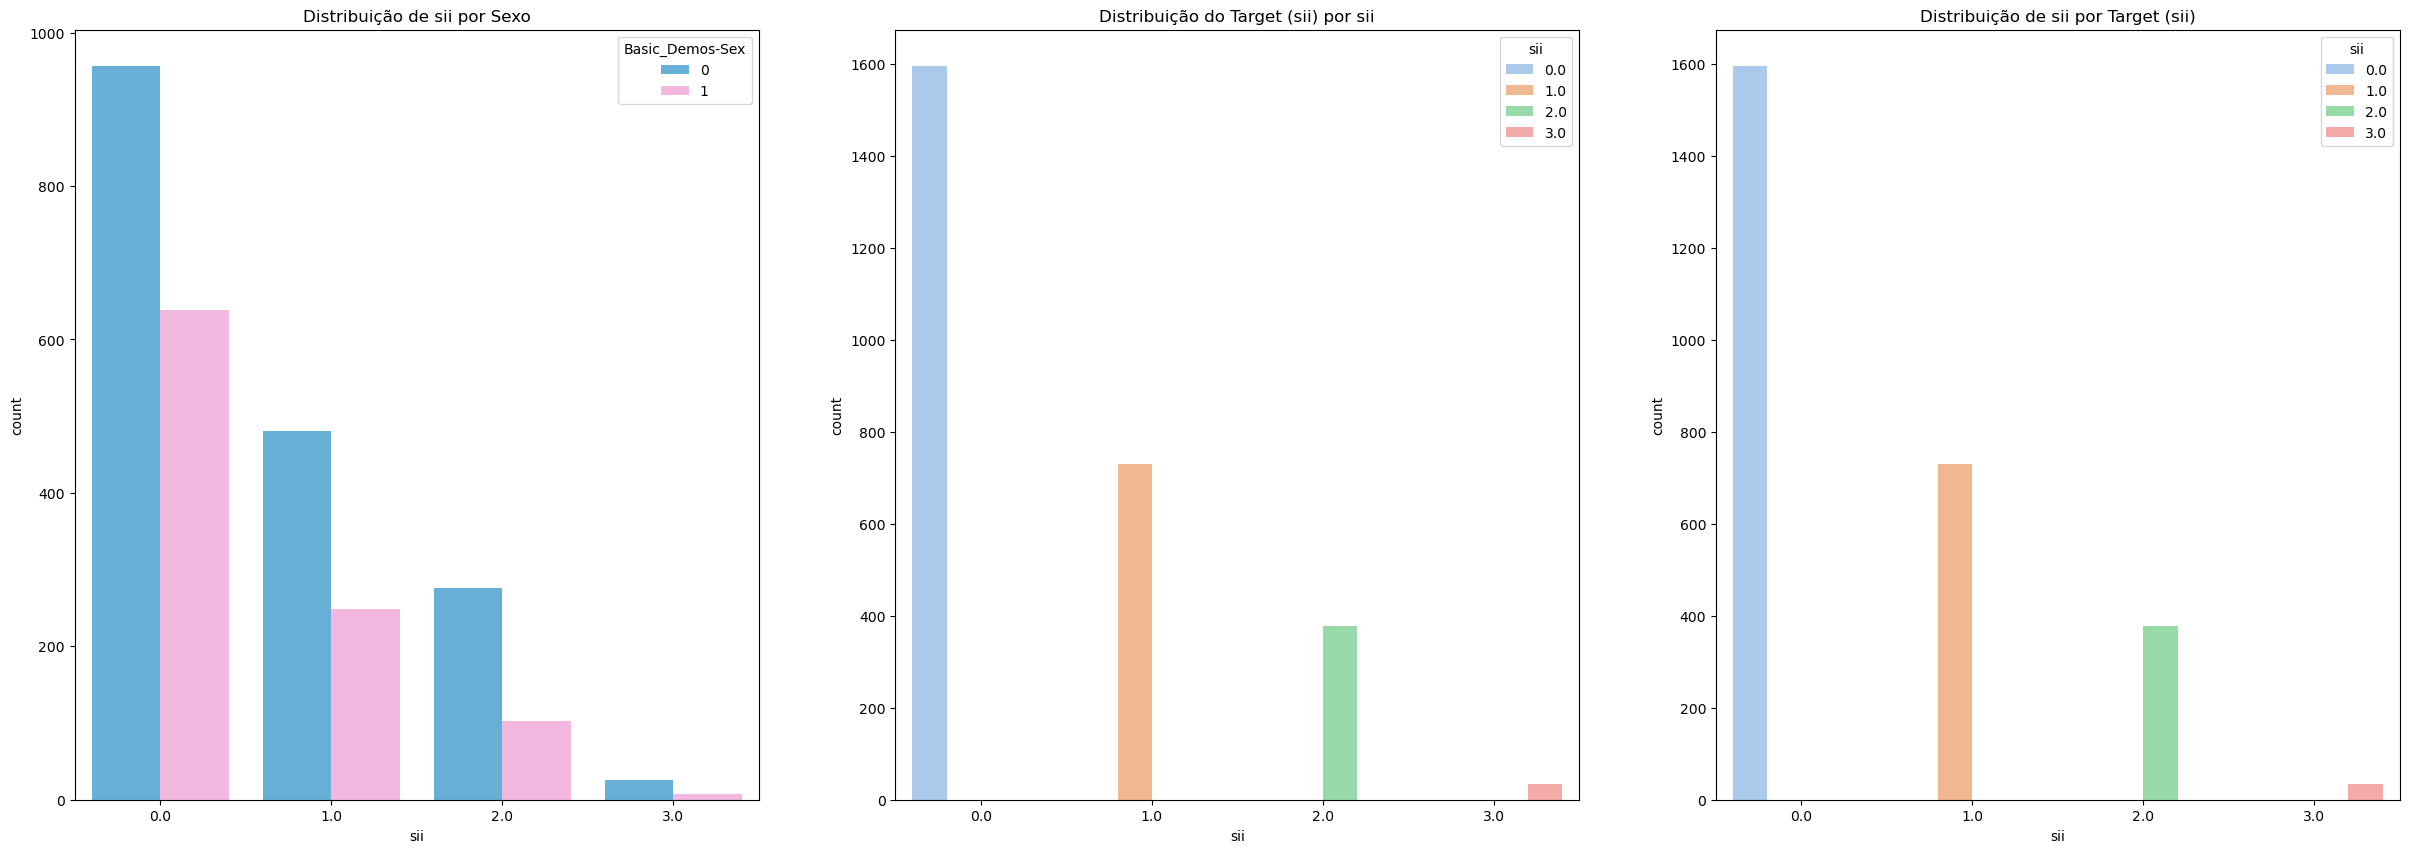

In [21]:
def analysis_categorical_variables(df_original, coluna):
    df = df_original.copy()
    
    # Atualiza tamanho padrão da fonte
    #plt.rcParams.update({'font.size': 15})

    fig1, axes1 = plt.subplots(1, 2, figsize=(20, 8))

    # Gráfico de densidade
    sns.kdeplot(data=df, x='Basic_Demos-Age', hue=coluna, fill=True, 
                palette='viridis', ax=axes1[0])
    axes1[0].set_title(f'DENSIDADE DE IDADE POR {coluna}', fontsize=25)
    axes1[0].set_xlabel('Idade', fontsize=20)
    axes1[0].set_ylabel('Densidade', fontsize=20)
    axes1[0].tick_params(axis='both', labelsize=17)

    # Pegando a legenda já criada e ajustando a fonte
    leg = axes1[0].get_legend()  # pegar a legenda existente
    leg.set_title(coluna, prop={'size':20})  # alterar o tamanho do título
    for text in leg.get_texts():
        text.set_fontsize(20)  # alterar o tamanho de cada item da legenda
    
    # Gráfico de contagem
    sns.countplot(x=coluna, data=df, palette='viridis', ax=axes1[1])
    axes1[1].set_title(f'FREQUÊNCIA DE OCORRÊNCIAS DE {coluna}', fontsize=25)
    axes1[1].set_xlabel(coluna, fontsize=20)
    axes1[1].set_ylabel('Contagem', fontsize=20)
    axes1[1].tick_params(axis='both', labelsize=17)
    
    # Adicionar porcentagens acima das barras
    total = len(df)
    for p in axes1[1].patches:
        altura = p.get_height()
        percentual = f'{100 * altura / total:.1f}%'
        axes1[1].text(
            p.get_x() + p.get_width() / 2,
            altura + 5,  # aumenta o espaço para a porcentagem não ficar colada
            percentual,
            ha='center',
            fontsize=20
        )
    
    # Ajustar layout
    plt.tight_layout()
    
    # Salvar a figura
    plt.savefig(f'img/{coluna}_fig1.png')
    
    fig2, axes2 = plt.subplots(1, 3, figsize=(30, 10))
    sns.countplot(data=df, x=coluna, hue='Basic_Demos-Sex', palette=["#56B4E9", "#FBAFE4"], ax=axes2[0])
    axes2[0].set_title(f"Distribuição de {coluna} por Sexo")    

    df['Basic_Demos-Age_Zone'] = pd.cut(df['Basic_Demos-Age'], 
                                        bins=[0, 10, 15, 20, 25, 30], 
                                        labels=['1', '2', '3', '4', '5'])
    sns.countplot(data=df, x='sii', hue=coluna, palette='pastel', ax=axes2[1])
    axes2[1].set_title(f"Distribuição do Target (sii) por {coluna}")
    
    sns.countplot(data=df, x=coluna, hue='sii', palette='pastel', ax=axes2[2])
    axes2[2].set_title(f"Distribuição de {coluna} por Target (sii)")
    plt.savefig(f'img/{coluna}_fig2.png')
    plt.show()

analysis_categorical_variables(df, 'sii')

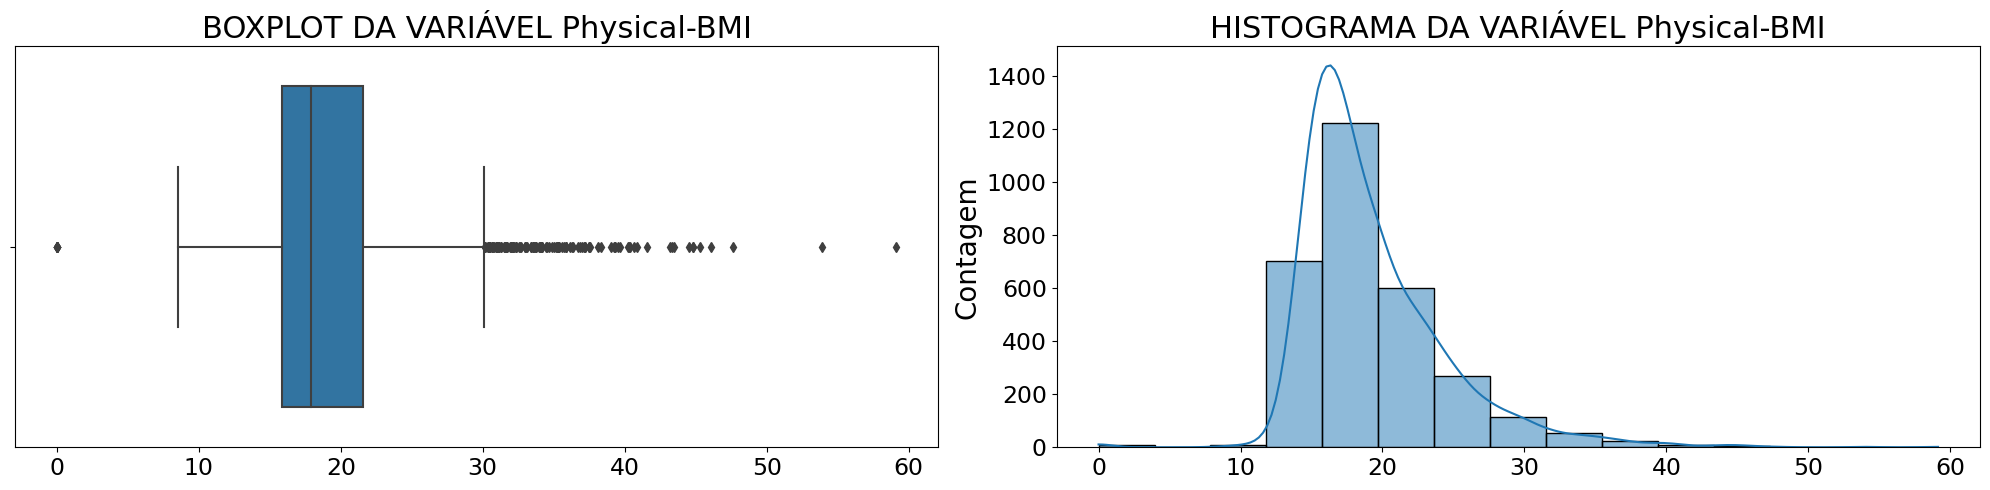

In [47]:
def analysis_continuous_variables(df_original, coluna):
    df = df_original.copy()
    fig1, axes1 = plt.subplots(1, 2, figsize=(20, 5))
    fontsize=20

    # Identificar possíveis outliers usando um boxplot
    sns.boxplot(x=df[coluna], ax=axes1[0])
    axes1[0].set_title(f'BOXPLOT DA VARIÁVEL {coluna}', fontsize=22)  # Aumenta o tamanho do título
    axes1[0].set_xlabel('')  # Aumenta o tamanho do nome do eixo X
    axes1[0].set_ylabel('', fontsize=fontsize)  # Caso queira também configurar o eixo Y
    axes1[0].tick_params(axis='both', labelsize=17)  # aumenta o tamanho dos números dos eixos
    
    # Histograma para visualizar a distribuição da variável
    sns.histplot(df[coluna], bins=15, kde=True, ax=axes1[1])
    axes1[1].set_title(f'HISTOGRAMA DA VARIÁVEL {coluna}', fontsize=22)  # Aumenta o tamanho do título
    axes1[1].set_xlabel('')  # Aumenta o tamanho do nome do eixo X
    axes1[1].set_ylabel('Contagem', fontsize=fontsize)  # Nomeia e aumenta a fonte do eixo Y
    axes1[1].tick_params(axis='both', labelsize=17)  # aumenta o tamanho dos números dos eixos
    
    # Ajustar layout para não cortar textos
    plt.tight_layout()
    
    # Salvar o gráfico
    plt.savefig(f'img/{coluna}_fig1.png')

    plt.show()

analysis_continuous_variables(df, 'Physical-BMI')

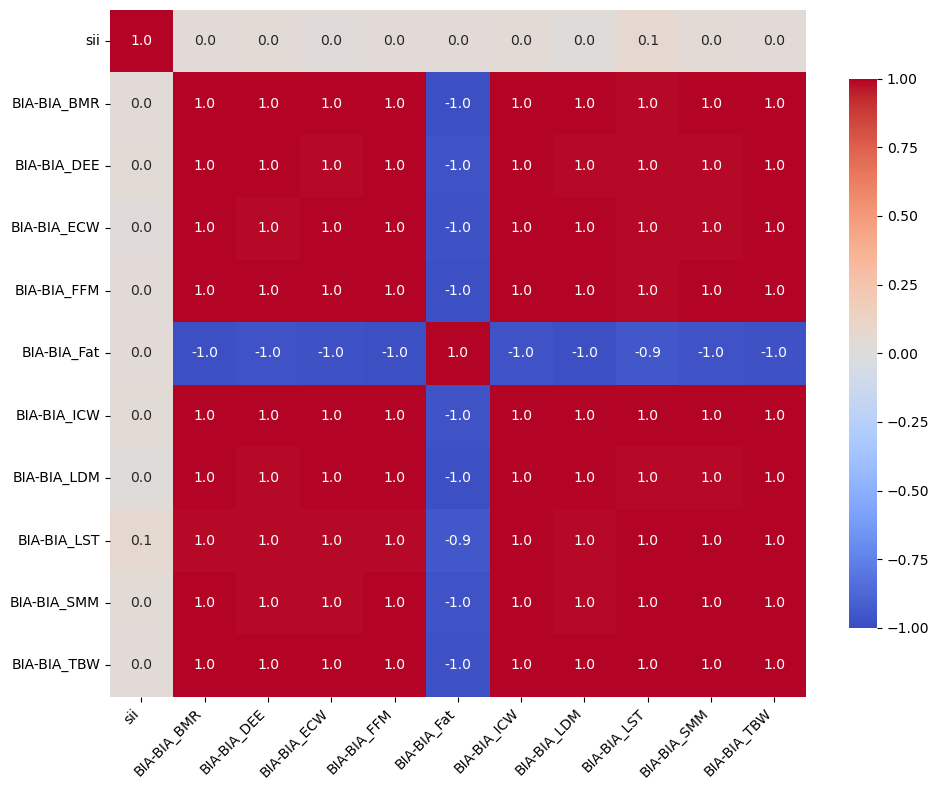

In [25]:
# 'BIA-BIA_Activity_Level_num','BIA-BIA_BMI','BIA-BIA_FFMI',
# 'BIA-BIA_FMI','BIA-BIA_Frame_num',
columns = ['sii','BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 
           'BIA-BIA_FFM', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 
           'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW']

# Filtrando as colunas desejadas
df_temp = df[columns]

# Calculando a matriz de correlação
correlation_matrix = df_temp.corr()

# Criando a figura
plt.figure(figsize=(10, 8))

# Gerando o heatmap com ajustes
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.1f',
    vmin=-1,
    vmax=1,
    annot_kws={"size": 10},   # aumenta a letra dos valores
    cbar_kws={"shrink": 0.8}  # diminui um pouco a barra de cores
)

# Ajustando os ticks dos eixos
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Ajustando o layout para não cortar os nomes
plt.tight_layout()

# Salvando a figura
plt.savefig('img/matrix-BIA.png')

# Exibindo o gráfico
plt.show()

In [28]:
columns = ['Physical-BMI','Physical-Weight',
    'BIA-BIA_FFMI','BIA-BIA_FMI','BIA-BIA_TBW','BIA-BIA_BMC']

df_temp =  df[columns]
indicadores = df_temp.describe()
indicadores

,Physical-BMI,Physical-Weight,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_TBW,BIA-BIA_BMC
count,3022.000000,3076.000000,1991.000000,1991.000000,1991.000000,1991.000000
mean,19.331929,89.038615,15.030554,4.336495,53.998726,6.719826
std,5.113934,44.569040,5.792505,6.356402,129.362539,92.586325
min,0.000000,0.000000,7.864850,-194.163000,20.589200,-7.789610
25%,15.869350,57.200000,13.408000,2.306915,35.887000,2.966905
50%,17.937682,77.000000,14.092500,3.698630,44.987000,3.922720
75%,21.571244,113.800000,15.430950,5.987690,60.271050,5.460925
max,59.132048,315.000000,217.771000,28.251500,5690.910000,4115.360000


In [29]:
missing_data = df_temp.isnull().sum().sort_values(ascending=False)
print(missing_data)

BIA-BIA_FFMI       1969
BIA-BIA_FMI        1969
BIA-BIA_TBW        1969
BIA-BIA_BMC        1969
Physical-BMI        938
Physical-Weight     884
dtype: int64


In [30]:
# Ajusta para exibir todas as linhas
pd.set_option("display.max_rows", None)

missing_percentage = (df.isnull().sum() / len(df)) * 100
print(missing_percentage.sort_values(ascending=False))

PAQ_A-PAQ_A_Total                         88.005051
PAQ_A-Season                              88.005051
Fitness_Endurance-Time_Sec                81.313131
Fitness_Endurance-Time_Mins               81.313131
Fitness_Endurance-Max_Stage               81.237374
Physical-Waist_Circumference              77.323232
FGC-FGC_GSND_Zone                         73.181818
FGC-FGC_GSD_Zone                          73.156566
FGC-FGC_GSND                              72.878788
FGC-FGC_GSD                               72.878788
Fitness_Endurance-Season                  66.969697
PAQ_C-Season                              56.540404
PAQ_C-PAQ_C_Total                         56.540404
BIA-BIA_FMI                               49.722222
BIA-BIA_BMR                               49.722222
BIA-BIA_BMI                               49.722222
BIA-BIA_DEE                               49.722222
BIA-BIA_FFM                               49.722222
BIA-BIA_FFMI                              49.722222
BIA-BIA_Acti

In [31]:
counts = df['sii'].value_counts()
print(counts)

0.0    1594
1.0     730
2.0     378
3.0      34
Name: sii, dtype: int64


In [32]:
# Pré-processamento dos Dados

# Transformador para remover colunas específicas
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns)  

In [33]:
class CombinePAQColumns(BaseEstimator, TransformerMixin):
    def __init__(self, adolescent_column, child_column, new_column):
        self.adolescent_column = adolescent_column
        self.child_column = child_column
        self.new_column = new_column

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        X[self.new_column] = np.nan
        X.loc[~X[self.adolescent_column].isna(), self.new_column] = X[self.adolescent_column]
        X.loc[~X[self.child_column].isna(), self.new_column] = X[self.child_column]

        # Remover as colunas originais
        X = X.drop(columns=[self.adolescent_column, self.child_column])
        return X

In [52]:
class RangePossibleValues(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass  

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        
        X.loc[X['Physical-BMI'] < 10, 'Physical-BMI'] = np.nan
        X.loc[X['Physical-BMI'] > 60, 'Physical-BMI'] = np.nan
        
        X.loc[X['BIA-BIA_FMI'] < 0, 'BIA-BIA_FMI'] = np.nan
        X.loc[X['BIA-BIA_FMI'] > 15, 'BIA-BIA_FMI'] = np.nan
        
        X.loc[X['BIA-BIA_FFMI'] < 12, 'BIA-BIA_FFMI'] = np.nan
        X.loc[X['BIA-BIA_FFMI'] > 22, 'BIA-BIA_FFMI'] = np.nan
        
        return X

In [36]:
# Transformador para imputação com LinearRegression
class PipModeloRegression(BaseEstimator, TransformerMixin):
    def __init__(self, faltante, limite_min=None, limite_max=None):
        self.faltante = faltante
        self.model = LinearRegression()
        self.limite_min = limite_min
        self.limite_max = limite_max

    def fit(self, X, y=None):
        # Identificar colunas sem valores nulos, exceto a coluna faltante
        self.colunas_sem_nulos = X.drop(columns=[self.faltante]).dropna(axis=1).columns.tolist()

        # Criar um subset de treino removendo linhas com valores nulos na coluna faltante
        df_temp = X[self.colunas_sem_nulos + [self.faltante]].dropna()
        
        # Treinar o modelo apenas se houver dados suficientes
        if df_temp.shape[0] > 0:
            self.model.fit(df_temp[self.colunas_sem_nulos], df_temp[self.faltante])
        return self

    def transform(self, X):
        X = X.copy()
        
        # Identificar linhas com valores ausentes na coluna faltante
        missing_data = X[self.faltante].isna()
        if missing_data.sum() > 0:
            # Preencher os valores ausentes usando as colunas sem nulos
            #X.loc[missing_data, self.faltante] = self.model.predict(X[self.colunas_sem_nulos][missing_data])
            
            # Prever valores ausentes
            previsoes = self.model.predict(X[self.colunas_sem_nulos][missing_data])
            
            # Aplicar limites se definidos
            if self.limite_min is not None or self.limite_max is not None:
                previsoes = np.clip(previsoes, self.limite_min, self.limite_max)
            
            # Substituir valores ausentes pela previsão ajustada
            X.loc[missing_data, self.faltante] = previsoes
            
            #print(f'{self.faltante}: {self.colunas_sem_nulos}')
        return X

In [37]:
# Transformador para imputação com LogisticRegression
class PipModeloLogisticRegression(BaseEstimator, TransformerMixin):
    def __init__(self, faltante):
        self.faltante = faltante
        self.model = LogisticRegression(class_weight='balanced',solver='liblinear',random_state=42)

    def fit(self, X, y=None):
        # Identificar colunas sem valores nulos, exceto a coluna com valores nulos
        self.colunas_sem_nulos = X.drop(columns=[self.faltante]).dropna(axis=1).columns.tolist()
        
        # Criar um subset sem valores nulos nas colunas correlacionadas e na coluna faltante
        #df_temp = X[self.colunas_correlacionadas + [self.faltante]].dropna()
        df_temp = X[self.colunas_sem_nulos + [self.faltante]].dropna()

        # Treina o modelo apenas se houver dados suficientes após a remoção de outliers
        if df_temp.shape[0] > 0:
            #self.model.fit(df_temp[self.colunas_correlacionadas], df_temp[self.faltante])
            self.model.fit(df_temp[self.colunas_sem_nulos], df_temp[self.faltante])
        return self

    def transform(self, X):
        X = X.copy()

        # Identificar linhas com valores ausentes na faltante
        missing_data = X[self.faltante].isna()
        if missing_data.sum() > 0:
            # Preencher os valores ausentes com as previsões do modelo
            #X.loc[missing_data, self.faltante] = self.model.predict(X[self.colunas_correlacionadas][missing_data])
            X.loc[missing_data, self.faltante] = self.model.predict(X[self.colunas_sem_nulos][missing_data])
        return X

In [41]:
# Transformador para normalizar colunas discretas
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.scaler = MinMaxScaler(feature_range=(-1, 1)) 
    
    def fit(self, X, y=None):
        # Ajusta o scaler apenas nas colunas passadas
        self.scaler.fit(X[self.columns])
        return self
    
    def transform(self, X):
        X = X.copy()
        X[self.columns] = self.scaler.transform(X[self.columns])
        return X

In [53]:
pipeline_with_null = Pipeline([
    ('drop_columns_1', DropColumns(columns=['Fitness_Endurance-Time_Sec','Fitness_Endurance-Time_Mins',
                                          'Fitness_Endurance-Max_Stage','Physical-Waist_Circumference',
                                          'FGC-FGC_GSND_Zone','FGC-FGC_GSD_Zone','FGC-FGC_GSD','FGC-FGC_GSND',
                                          'Fitness_Endurance-Season'])),
    ('drop_columns_2', DropColumns(columns=['Basic_Demos-Enroll_Season', 'CGAS-Season', 
                                          'Physical-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
                                          'PAQ_C-Season', 'SDS-Season','PreInt_EduHx-Season'])),

    ('paq_total', CombinePAQColumns('PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'PAQ_Total')),
    ('drop_outlier', RangePossibleValues()),
    ('drop_columns_21', DropColumns(columns=['BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 
                                            'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_BMC', 
                                            'BIA-BIA_SMM', 'BIA-BIA_TBW','BIA-BIA_BMI'])),
    ('drop_columns_22', DropColumns(columns=['FGC-FGC_PU','FGC-FGC_CU','FGC-FGC_SRL','FGC-FGC_SRR',
                                             'FGC-FGC_TL','Physical-Weight','Physical-Height'])),
])

In [54]:
preprocessing_pipeline = Pipeline([
    ('drop_columns_1', DropColumns(columns=['Fitness_Endurance-Time_Sec','Fitness_Endurance-Time_Mins',
                                          'Fitness_Endurance-Max_Stage','Physical-Waist_Circumference',
                                          'FGC-FGC_GSND_Zone','FGC-FGC_GSD_Zone','FGC-FGC_GSD','FGC-FGC_GSND',
                                          'Fitness_Endurance-Season'])),
    ('drop_columns_2', DropColumns(columns=['Basic_Demos-Enroll_Season', 'CGAS-Season', 
                                          'Physical-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
                                          'PAQ_C-Season', 'SDS-Season','PreInt_EduHx-Season'])),
    ('paq_total', CombinePAQColumns('PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'PAQ_Total')),
    ('drop_outlier', RangePossibleValues()),
    ('drop_columns_21', DropColumns(columns=['BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 
                                            'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_BMC', 
                                            'BIA-BIA_SMM', 'BIA-BIA_TBW','BIA-BIA_BMI'])),
    ('drop_columns_22', DropColumns(columns=['FGC-FGC_PU','FGC-FGC_CU','FGC-FGC_SRL','FGC-FGC_SRR',
                                             'FGC-FGC_TL','Physical-Weight','Physical-Height'])),
    ('fill_bmi', PipModeloRegression(faltante='Physical-BMI')),
    ('fill_total_t', PipModeloRegression(faltante='SDS-SDS_Total_T')),
    ('fill_total_raw', PipModeloRegression(faltante='SDS-SDS_Total_Raw')),
    ('fill_ffmi', PipModeloRegression(faltante='BIA-BIA_FFMI')),
    ('fill_lst', PipModeloRegression(faltante='BIA-BIA_LST')),
    ('fill_fmi', PipModeloRegression(faltante='BIA-BIA_FMI')),
    ('fill_srl', PipModeloLogisticRegression(faltante='FGC-FGC_SRL_Zone')),
    ('fill_srr', PipModeloLogisticRegression(faltante='FGC-FGC_SRR_Zone')),
    ('fill_tl', PipModeloLogisticRegression(faltante='FGC-FGC_TL_Zone')),
    ('fill_int', PipModeloLogisticRegression(faltante='PreInt_EduHx-computerinternet_hoursday')),
    ('fill_paq', PipModeloRegression(faltante='PAQ_Total')),
    ('fill_cgas', PipModeloRegression(faltante='CGAS-CGAS_Score')),
    ('drop_columns_23', DropColumns(columns=['Physical-Systolic_BP','Physical-Diastolic_BP',
                                             'Physical-HeartRate','BIA-BIA_Frame_num',
                                             'BIA-BIA_Activity_Level_num','FGC-FGC_CU_Zone',
                                             'FGC-FGC_PU_Zone'])),    
    ('undersample', RandomUnderSampler(sampling_strategy={0: 1200}, random_state=42)),
    ('oversample', SMOTE(sampling_strategy={1: 900, 2: 700, 3: 300}, k_neighbors=5, random_state=42)),
])

In [42]:
prediction_pipeline = Pipeline([
    ('scale', Scaler(columns=['Basic_Demos-Age','Basic_Demos-Sex','CGAS-CGAS_Score','PAQ_Total',
                                           'PreInt_EduHx-computerinternet_hoursday','SDS-SDS_Total_T',
                                           'SDS-SDS_Total_Raw','BIA-BIA_LST','BIA-BIA_FMI','BIA-BIA_FFMI',
                                           'FGC-FGC_TL_Zone','FGC-FGC_SRR_Zone','FGC-FGC_SRL_Zone',
                                           'Physical-BMI'])),
])

In [55]:
# train_df = pd.read_csv('dados/train.csv')

X_train = train_df.dropna(subset=['sii'])
y_train = X_train['sii']

X_train = X_train.drop(columns=['PCIAT-PCIAT_01','PCIAT-PCIAT_02','PCIAT-PCIAT_03','PCIAT-PCIAT_04','PCIAT-PCIAT_05','PCIAT-PCIAT_06',
             'PCIAT-PCIAT_07','PCIAT-PCIAT_08','PCIAT-PCIAT_09','PCIAT-PCIAT_10','PCIAT-PCIAT_11','PCIAT-PCIAT_12',
             'PCIAT-PCIAT_13','PCIAT-PCIAT_14','PCIAT-PCIAT_15','PCIAT-PCIAT_16','PCIAT-PCIAT_17','PCIAT-PCIAT_18',
             'PCIAT-PCIAT_19','PCIAT-PCIAT_20','PCIAT-PCIAT_20','PCIAT-PCIAT_Total','PCIAT-Season','sii','id'])

# Aplicando o pipeline no conjunto de treino
df_with_null = pipeline_with_null.fit_transform(X_train)

# Roda 1 etapa do Pipeline (preprocessing)
X_train_resampled, y_train_resampled = preprocessing_pipeline.fit_resample(X_train, y_train) 
df_preprocessing = pd.DataFrame(X_train_resampled)
df_preprocessing['sii'] = y_train_resampled

X_train_final = prediction_pipeline.fit_transform(X_train_resampled, y_train_resampled)
df_train = pd.DataFrame(X_train_final)
df_train['sii'] = y_train_resampled

In [44]:
missing_percentage = (df_train.isnull().sum() / len(df_train)) * 100
print(missing_percentage.sort_values(ascending=False))

Basic_Demos-Age                           0.0
Basic_Demos-Sex                           0.0
CGAS-CGAS_Score                           0.0
Physical-BMI                              0.0
FGC-FGC_SRL_Zone                          0.0
FGC-FGC_SRR_Zone                          0.0
FGC-FGC_TL_Zone                           0.0
BIA-BIA_FFMI                              0.0
BIA-BIA_FMI                               0.0
BIA-BIA_LST                               0.0
SDS-SDS_Total_Raw                         0.0
SDS-SDS_Total_T                           0.0
PreInt_EduHx-computerinternet_hoursday    0.0
PAQ_Total                                 0.0
sii                                       0.0
dtype: float64


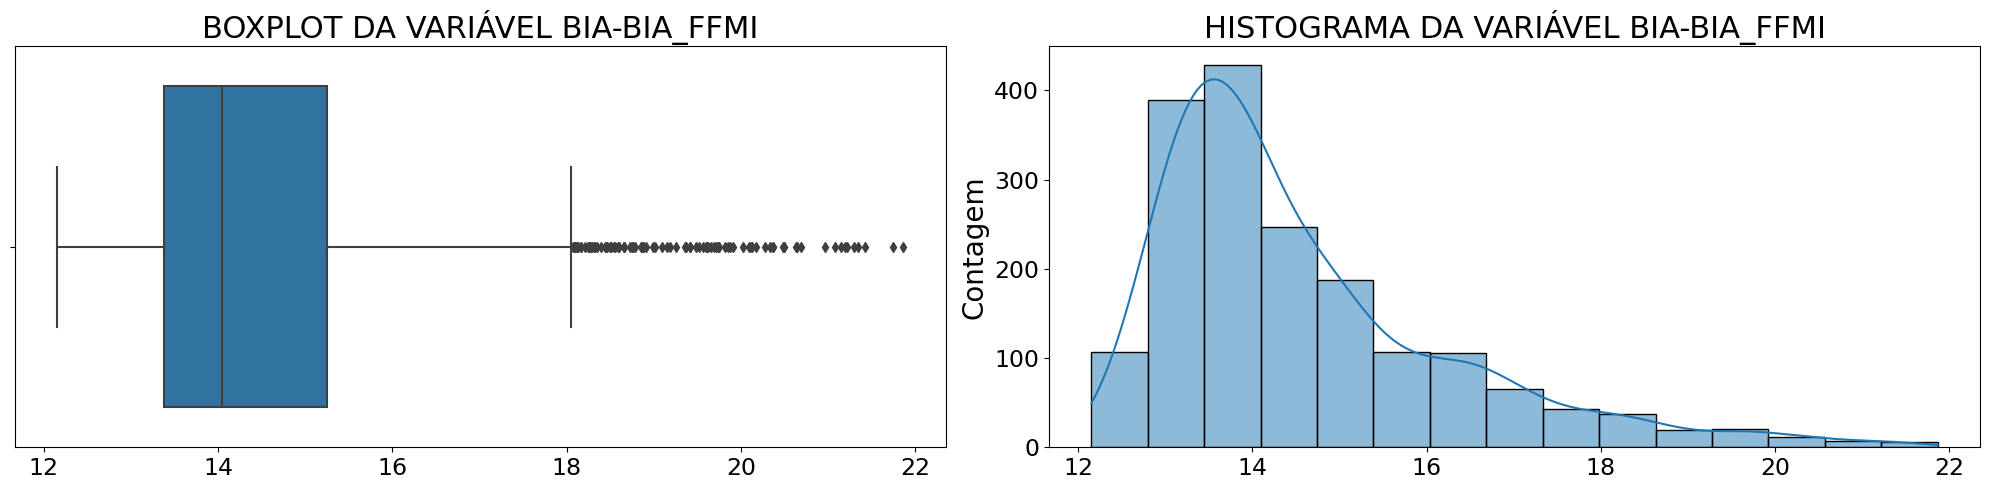

In [56]:
analysis_continuous_variables(df_with_null, 'BIA-BIA_FFMI')

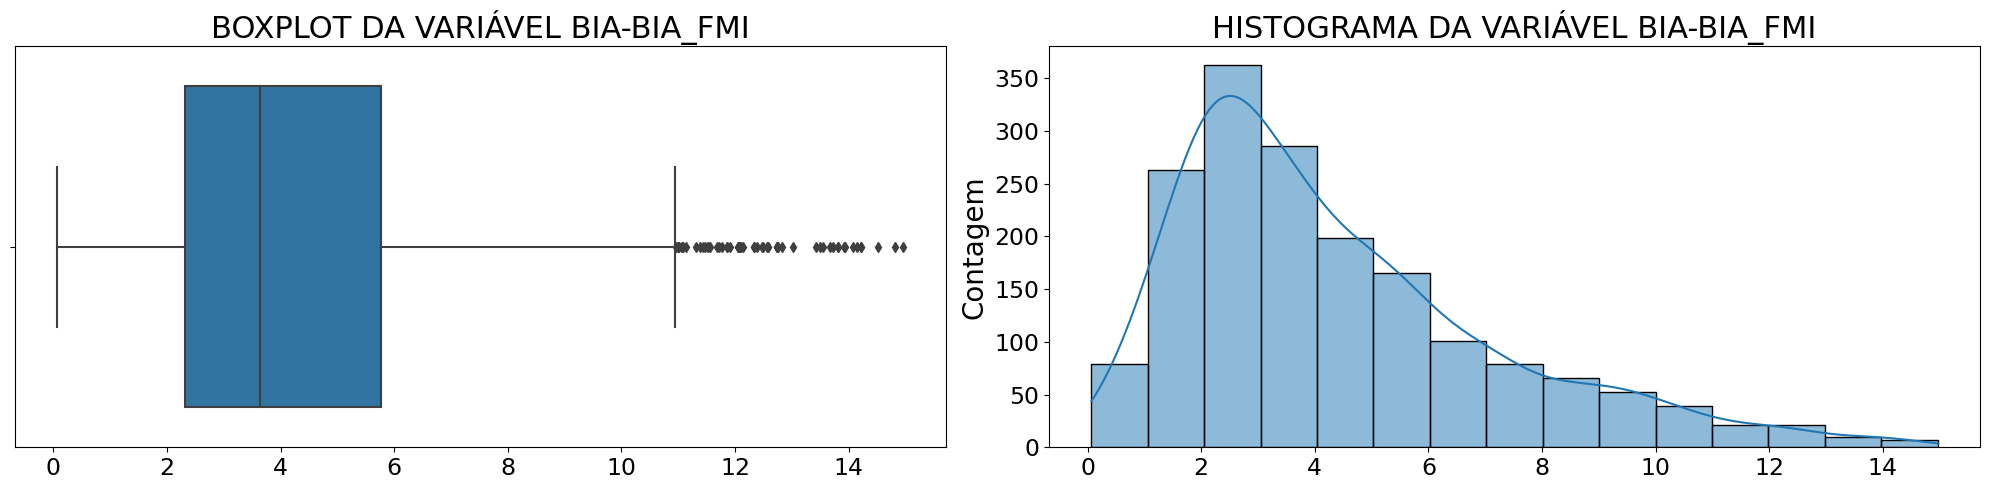

In [57]:
analysis_continuous_variables(df_with_null, 'BIA-BIA_FMI')

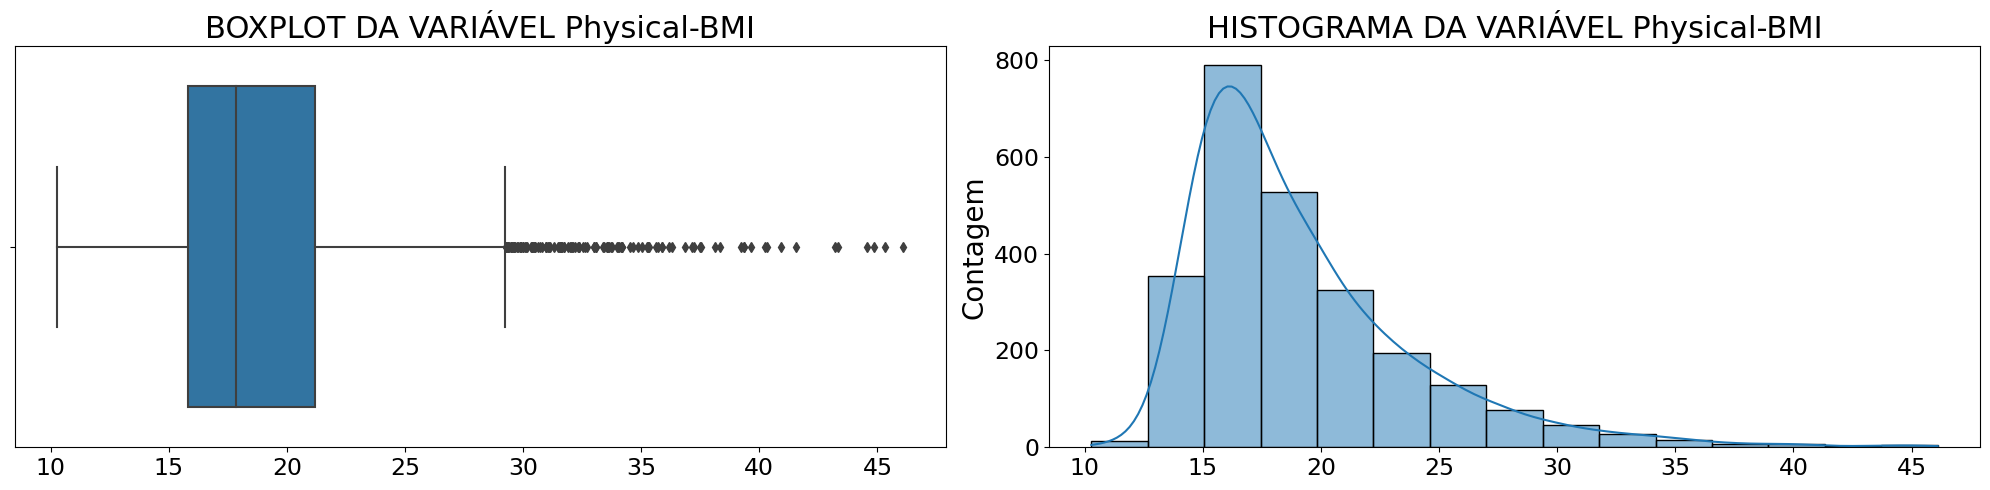

In [58]:
analysis_continuous_variables(df_with_null, 'Physical-BMI')

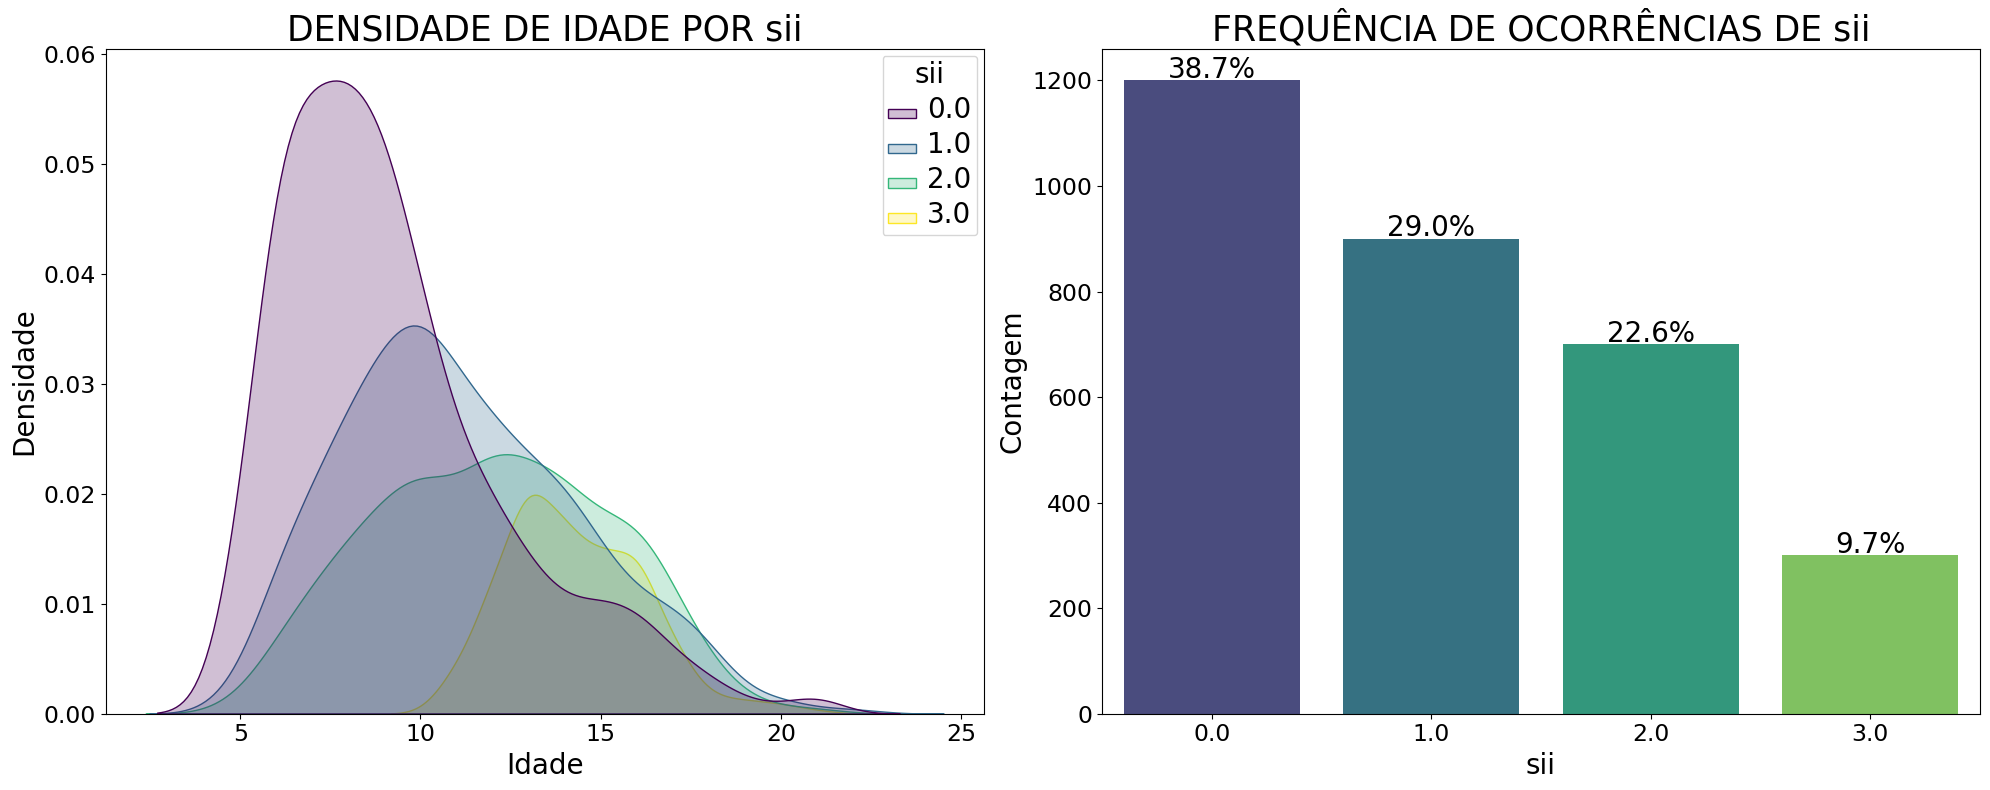

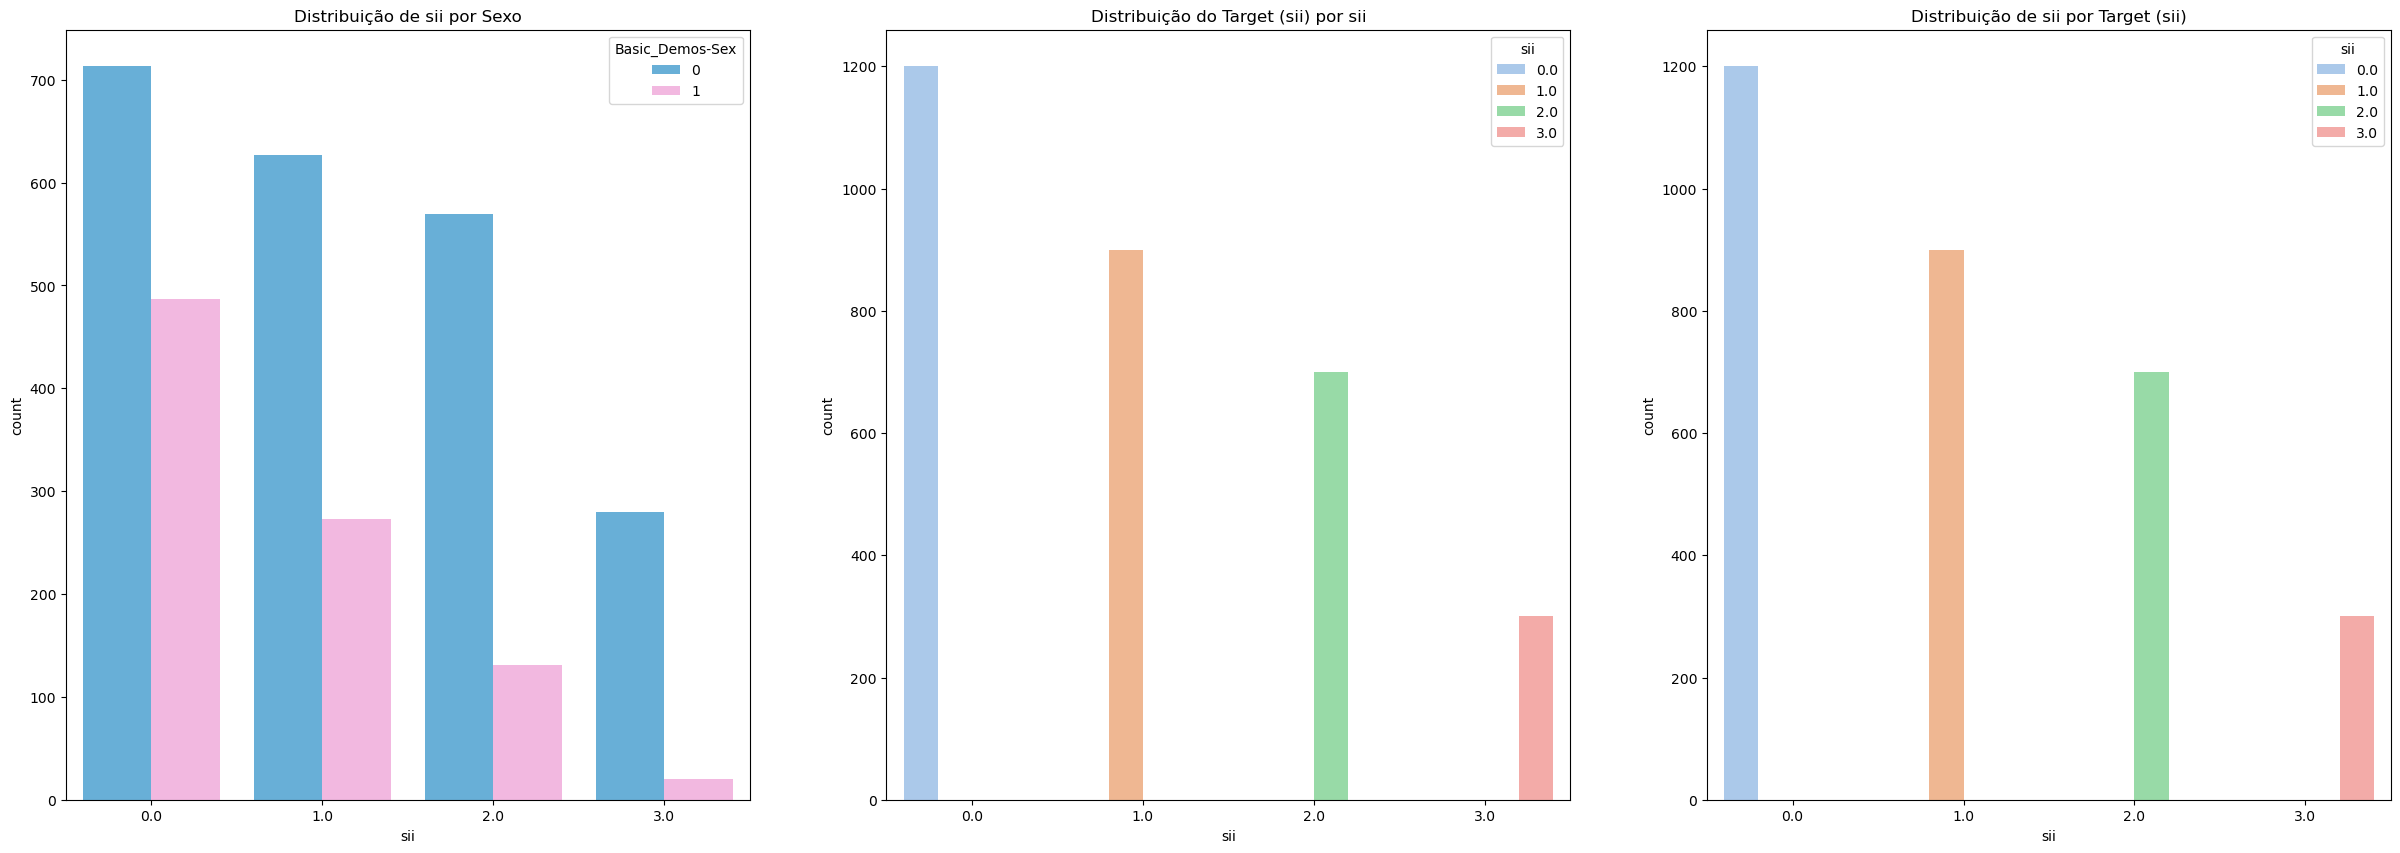

In [59]:
analysis_categorical_variables(df_preprocessing, 'sii')

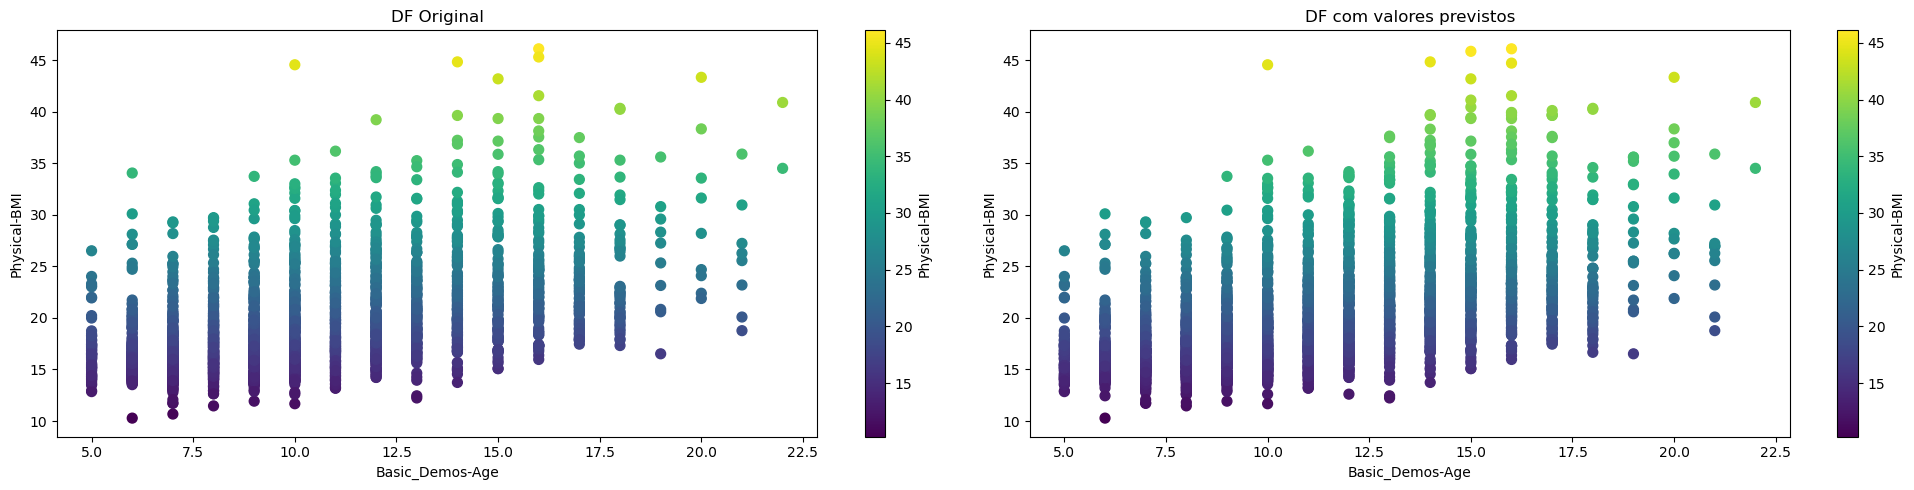

In [60]:
x = 'Basic_Demos-Age'
y = 'Physical-BMI'
z = 'Physical-BMI'

analysis_pipeline(df_with_null, df_preprocessing, x, y, z)

In [61]:
# Treinamento do Modelo

def add_df(df, colunas, modelo, accuracy=None, precision=None, recall=None, 
           f1=None, mse=None, mae=None, r2=None):
    df.loc[len(df)] = {
        'colunas': colunas,
        'modelo': modelo,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'mse': mse,
        'mae': mae,
        'r2': r2
    }

In [62]:
def preprocess_dataframe(df, target, colunas=None, test_size=0.2, random_state=42):
    # Remover linhas onde o target é nulo
    df = df[df[target].notnull()]
    
    # Remover colunas especificadas, se fornecido
    if colunas:
        df = df.drop(columns=colunas, errors='ignore')
    
    # Remover colunas que possuem qualquer valor nulo
    df = df.dropna(axis=1)
    
    # Separar variáveis explicativas e variável-alvo
    X = df.drop(columns=[target])
    y = df[target]
    
    # Dividir os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size, # 20% para o conjunto de teste
                                                        random_state=random_state, # Para garantir reprodutibilidade
                                                        stratify=y  # Garantir que a distribuição das classes seja mantida
                                                       )
    return X_train, X_test, y_train, y_test

In [63]:
# Modelo de regressão

def modeloExtraTreesRegressor(X_train, X_test, y_train, y_test, test_size=0.2, 
                              random_state=42, n_estimators=100, **model_params):
    
    # Configurar e treinar o modelo Extra Trees Regressor
    et_model = ExtraTreesRegressor(n_estimators=n_estimators, random_state=random_state, **model_params)
    et_model.fit(X_train, y_train)
    
    # Fazer previsões no conjunto de teste
    y_pred = et_model.predict(X_test)
    
    # Calcular métricas de desempenho
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, mae, r2

In [64]:
def modeloSVR(X_train, X_test, y_train, y_test, test_size=0.2,
              random_state=42, kernel='rbf', scale_data=True, **model_params):
    
    # Padronizar os dados (recomendado para SVR)
    if scale_data:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    # Configurar e treinar o modelo SVR
    svr_model = SVR(kernel=kernel, **model_params)
    svr_model.fit(X_train, y_train)
    
    # Fazer previsões no conjunto de teste
    y_pred = svr_model.predict(X_test)
    
    # Calcular métricas de desempenho
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, mae, r2 

In [65]:
def modeloMLPRegressor(X_train, X_test, y_train, y_test, test_size=0.2, random_state=42, 
                       hidden_layer_sizes=(100,), max_iter=1000, scale_data=True, **model_params):
    
    # Padronizar os dados (opcional, recomendado para redes neurais)
    if scale_data:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    # Configurar e treinar o modelo MLP Regressor
    mlp_model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, random_state=random_state, **model_params)
    mlp_model.fit(X_train, y_train)
    
    # Fazer previsões no conjunto de teste
    y_pred = mlp_model.predict(X_test)
    
    # Calcular métricas de desempenho
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, mae, r2

In [66]:
def modeloRegressaoLinear(X_train, X_test, y_train, y_test, test_size=0.2, random_state=42):
    
    # Configurar e treinar o modelo de Regressão Linear
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # Fazer previsões no conjunto de teste
    y_pred = lr_model.predict(X_test)
    
    # Calcular métricas de desempenho
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, mae, r2

In [67]:
def modeloGradientBoostingRegressor(X_train, X_test, y_train, y_test, model_type="xgboost", 
                                    test_size=0.2, random_state=42, **model_params):
    
    # Escolher o modelo de acordo com o tipo
    if model_type.lower() == "xgboost":
        model = XGBRegressor(random_state=random_state, **model_params)
    elif model_type.lower() == "lightgbm":
        model = LGBMRegressor(random_state=random_state, **model_params)
    elif model_type.lower() == "catboost":
        model = CatBoostRegressor(random_state=random_state, verbose=0, **model_params)
    else:
        raise ValueError("model_type must be 'xgboost', 'lightgbm', or 'catboost'")
    
    # Treinar o modelo
    model.fit(X_train, y_train)
    
    # Fazer previsões no conjunto de teste
    y_pred = model.predict(X_test)
    
    # Calcular métricas de desempenho
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, mae, r2

In [68]:
def modeloRandomForestRegressor(X_train, X_test, y_train, y_test, test_size=0.2, random_state=42, n_estimators=100):
    
    # Configurar e treinar o modelo Random Forest
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf_model.fit(X_train, y_train)
    
    # Fazer previsões no conjunto de teste
    y_pred = rf_model.predict(X_test)
    
    # Calcular métricas de avaliação
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, mae, r2

In [69]:
def modelo_regressor(df, df_model_result, target):
    X_train, X_test, y_train, y_test = preprocess_dataframe(df, target)
    columns_name = df.columns.tolist()
    
    mse, mae, r2 = modeloExtraTreesRegressor(X_train, X_test, y_train, y_test)
    add_df(df_model_result, columns_name, 'modeloExtraTreesRegressor', mse=mse, mae=mae, r2=r2)
    
    mse, mae, r2 = modeloSVR(X_train, X_test, y_train, y_test)
    add_df(df_model_result, columns_name, 'modeloSVR', mse=mse, mae=mae, r2=r2)
    
    mse, mae, r2 = modeloMLPRegressor(X_train, X_test, y_train, y_test)
    add_df(df_model_result, columns_name, 'modeloMLPRegressor', mse=mse, mae=mae, r2=r2)
    
    mse, mae, r2 = modeloRegressaoLinear(X_train, X_test, y_train, y_test)
    add_df(df_model_result, columns_name, 'modeloRegressaoLinear', mse=mse, mae=mae, r2=r2)
    
    mse, mae, r2 = modeloGradientBoostingRegressor(X_train, X_test, y_train, y_test)
    add_df(df_model_result, columns_name, 'modeloGradientBoostingRegressor', mse=mse, mae=mae, r2=r2)
    
    mse, mae, r2 = modeloRandomForestRegressor(X_train, X_test, y_train, y_test)
    add_df(df_model_result, columns_name, 'modeloRandomForestRegressor', mse=mse, mae=mae, r2=r2)

    return df_model_result

In [81]:
# Modelo de classificação

def print_details_modelo(y_test, y_pred, y_proba, rf_model, nome_modelo):
    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    plt.figure(figsize=(10, 10))
    disp.plot(cmap='Blues')
    plt.title("Matriz de Confusão")
    plt.savefig(f'img/confusion_matrix_RandomForestClassifier.png')
    plt.show()

    # Importância das Features
    importances = rf_model.feature_importances_
    features = X_train.columns
    df_feat = pd.DataFrame({'feature': features, 'importance': importances})
    df_feat = df_feat.sort_values(by='importance', ascending=False)

    sns.barplot(x='importance', y='feature', data=df_feat.head(10))
    plt.title("Top 10 Features - Random Forest")
    plt.tight_layout()
    plt.savefig(f'img/feature_importance_{nome_modelo}.png')
    plt.show()

    # Curva ROC para cada classe
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)
    for i in range(len(classes)):
        RocCurveDisplay.from_predictions(y_test_bin[:, i], y_proba[:, i], name=f'Classe {classes[i]}')
    plt.title("Curva ROC por Classe")
    plt.savefig(f'img/roc_curve_{nome_modelo}.png')
    plt.show()

    # Curva Precision-Recall para cada classe
    for i in range(len(classes)):
        PrecisionRecallDisplay.from_predictions(y_test_bin[:, i], y_proba[:, i], name=f'Classe {classes[i]}')
        plt.savefig(f'img/precision_recall_{nome_modelo}_{classes[i]}.png')
    plt.title("Curva Precision-Recall por Classe")
    plt.show()

    # Confiança das previsões
    max_proba = np.max(y_proba, axis=1)
    plt.hist(max_proba, bins=20, color='skyblue', edgecolor='black')
    plt.title("Confiança das Previsões")
    plt.xlabel("Maior probabilidade predita")
    plt.ylabel("Número de amostras")
    plt.savefig(f'img/prediction_confidence_{nome_modelo}.png')
    plt.show()

In [71]:
def modeloRandomForestClassifier(X_train, X_test, y_train, y_test, random_state=42, n_estimators=100, 
                                 print_details=False, average='macro'):
    # Configurar e treinar o modelo Random Forest Classifier
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    rf_model.fit(X_train, y_train)
    
    # Fazer previsões no conjunto de teste
    y_pred = rf_model.predict(X_test)
    y_proba = rf_model.predict_proba(X_test)
    
    # Calcular métricas de desempenho
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=average, zero_division=1)
    recall = recall_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average, zero_division=1)
    
    if print_details:
        print_details_modelo(y_test, y_pred, y_proba, rf_model, 'RandomForestClassifier')
    
    return accuracy, precision, recall, f1

In [72]:
def modeloKNN(X_train, X_test, y_train, y_test, n_neighbors=5, scale_data=True, print_details=False, average='macro'):    
    # Padronizar os dados (opcional, recomendado para KNN)
    if scale_data:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    # Configurar e treinar o modelo KNN
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_model.fit(X_train, y_train)
    
    # Fazer previsões no conjunto de teste
    y_pred = knn_model.predict(X_test)
    
    # Calcular métricas de desempenho
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=average, zero_division=1)
    recall = recall_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average, zero_division=1)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    confusion = confusion_matrix(y_test, y_pred)
    
    if print_details:
        print('\n\033[1m K-Nearest Neighbors (KNN) \033[0m')
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        print("\nConfusion Matrix:")
        print(confusion)
    
    return accuracy, precision, recall, f1

In [73]:
def modeloGradientBoostingClassifier(X_train, X_test, y_train, y_test, random_state=42, average='macro',
                                     model_type="xgboost", print_details=False, **model_params):    
    # Escolher o modelo de acordo com o tipo
    if model_type.lower() == "xgboost":
        model = XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='logloss', **model_params)
    elif model_type.lower() == "lightgbm":
        model = LGBMClassifier(random_state=random_state, **model_params)
    elif model_type.lower() == "catboost":
        model = CatBoostClassifier(random_state=random_state, verbose=0, **model_params)
    else:
        raise ValueError("model_type must be 'xgboost', 'lightgbm', or 'catboost'")
    
    # Treinar o modelo
    model.fit(X_train, y_train)
    
    # Fazer previsões no conjunto de teste
    y_pred = model.predict(X_test)
    
    # Calcular métricas de desempenho
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=average, zero_division=1)
    recall = recall_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average, zero_division=1)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    confusion = confusion_matrix(y_test, y_pred)
    
    if print_details:
        print('\n\033[1m Gradient Boosting Classifiers (XGBoost, LightGBM, CatBoost) \033[0m')
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        print("\nConfusion Matrix:")
        print(confusion)

    return accuracy, precision, recall, f1

In [74]:
def modeloLogisticRegression(X_train, X_test, y_train, y_test, random_state=42, average='macro' ,
                             scale_data=True, print_details=False, **model_params):
    # Padronizar os dados (opcional, recomendado para regressão logística)
    if scale_data:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    # Configurar e treinar o modelo LogisticRegression
    lr_model = LogisticRegression(random_state=random_state, **model_params)
    lr_model.fit(X_train, y_train)
    
    # Fazer previsões no conjunto de teste
    y_pred = lr_model.predict(X_test)
    
    # Calcular métricas de desempenho
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=average, zero_division=1)
    recall = recall_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average, zero_division=1)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    confusion = confusion_matrix(y_test, y_pred)
    
    if print_details: 
        print('\n\033[1m Regressão Logística Multinomial (Logistic Regression) \033[0m')
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        print("\nConfusion Matrix:")
        print(confusion)

        # Obter os coeficientes das variáveis
        coefficients = pd.DataFrame({
            'Feature': X_train.columns,
            'Coefficient': lr_model.coef_[0] if lr_model.coef_.ndim > 1 else lr_model.coef_
        }).sort_values(by='Coefficient', ascending=False)
        
        print("\nCoeficientes das Variáveis:")
        print(coefficients)
        
    return accuracy, precision, recall, f1

In [75]:
def modeloNaiveBayes(X_train, X_test, y_train, y_test, scale_data=True, print_details=False, average='macro'):
    # Padronizar os dados (opcional, pode ajudar para GaussianNB com dados contínuos)
    if scale_data:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    # Configurar e treinar o modelo Naive Bayes (GaussianNB para dados contínuos)
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    
    # Fazer previsões no conjunto de teste
    y_pred = nb_model.predict(X_test)
    
    # Calcular métricas de desempenho
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=average, zero_division=1)
    recall = recall_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average, zero_division=1)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    confusion = confusion_matrix(y_test, y_pred)
    
    if print_details:
        print('\n\033[1m Naive Bayes \033[0m')
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        print("\nConfusion Matrix:")
        print(confusion)
        
    return accuracy, precision, recall, f1

In [76]:
def modeloMLPClassifier(X_train, X_test, y_train, y_test, random_state=42, print_details=False,
                        hidden_layer_sizes=(100,), max_iter=200, scale_data=True, average='macro'):    
    # Padronizar os dados (opcional, recomendado para MLP)
    if scale_data:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    # Configurar e treinar o modelo MLP
    mlp_model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, random_state=random_state)
    mlp_model.fit(X_train, y_train)
    
    # Fazer previsões no conjunto de teste
    y_pred = mlp_model.predict(X_test)
    
    # Calcular métricas de desempenho
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=average, zero_division=1)
    recall = recall_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average, zero_division=1)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    confusion = confusion_matrix(y_test, y_pred)
    
    if print_details: 
        print('\n\033[1m MLP Classifier (Rede Neural Artificial) \033[0m')
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        print("\nConfusion Matrix:")
        print(confusion)
    
    return accuracy, precision, recall, f1

In [77]:
def modelo_classificacao(df, df_model_result, target, average='macro', scale_data=True):
    X_train, X_test, y_train, y_test = preprocess_dataframe(df, target)
    columns_name = df.columns.tolist()
    
    accuracy, precision, recall, f1 = modeloRandomForestClassifier(X_train, X_test, y_train, y_test, average=average)
    add_df(df_model_result, columns_name, 'modeloRandomForestClassifier', accuracy=accuracy, precision=precision, recall=recall, f1=f1)
    
    accuracy, precision, recall, f1 = modeloKNN(X_train, X_test, y_train, y_test, average=average, scale_data=scale_data)
    add_df(df_model_result, columns_name, 'modeloKNN', accuracy=accuracy, precision=precision, recall=recall, f1=f1)
    
    ##accuracy = modeloGradientBoostingClassifier(X_train, X_test, y_train, y_test)
    ##add_df(df_model_result, columns_name, 'modeloGradientBoostingClassifier', accuracy)
    
    accuracy, precision, recall, f1 = modeloNaiveBayes(X_train, X_test, y_train, y_test, average=average, scale_data=scale_data)
    add_df(df_model_result, columns_name, 'modeloNaiveBayes', accuracy=accuracy, precision=precision, recall=recall, f1=f1)
    
    accuracy, precision, recall, f1 = modeloMLPClassifier(X_train, X_test, y_train, y_test, max_iter=500, 
                                                          average=average, scale_data=scale_data)
    add_df(df_model_result, columns_name, 'modeloMLPClassifier', accuracy=accuracy, precision=precision, recall=recall, f1=f1)
    
    accuracy, precision, recall, f1 = modeloLogisticRegression(X_train, X_test, y_train, y_test, 
                                                               scale_data=scale_data, max_iter=300, average=average)
    add_df(df_model_result, columns_name, 'modeloLogisticRegression', accuracy=accuracy, precision=precision, recall=recall, f1=f1)

    return df_model_result

In [79]:
# Variáveis TARGET 
df_result_classificacao = pd.DataFrame(columns=['colunas', 'modelo', 'accuracy', 'precision', 'recall', 'f1','mse', 'mae', 'r2'])
df_result_classificacao = modelo_classificacao(df_train, df_result_classificacao, 'sii') 

df_sorted = df_result_classificacao.sort_values(by='precision', ascending=False)
df_sorted = df_sorted.reset_index(drop=True)
df_sorted.head(5)

C:\Users\Luana\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Luana\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,colunas,modelo,accuracy,precision,recall,f1,mse,mae,r2
0,"[Basic_Demos-Age, Basic_Demos-Sex, CGAS-CGAS_S...",modeloRandomForestClassifier,0.624194,0.642651,0.652480,0.644535,None,None,None
1,"[Basic_Demos-Age, Basic_Demos-Sex, CGAS-CGAS_S...",modeloMLPClassifier,0.582258,0.626111,0.621478,0.623707,None,None,None
2,"[Basic_Demos-Age, Basic_Demos-Sex, CGAS-CGAS_S...",modeloKNN,0.572581,0.584667,0.610218,0.590952,None,None,None
3,"[Basic_Demos-Age, Basic_Demos-Sex, CGAS-CGAS_S...",modeloNaiveBayes,0.459677,0.468994,0.471280,0.439502,None,None,None
4,"[Basic_Demos-Age, Basic_Demos-Sex, CGAS-CGAS_S...",modeloLogisticRegression,0.482258,0.442691,0.440923,0.437173,None,None,None


<Figure size 1000x1000 with 0 Axes>

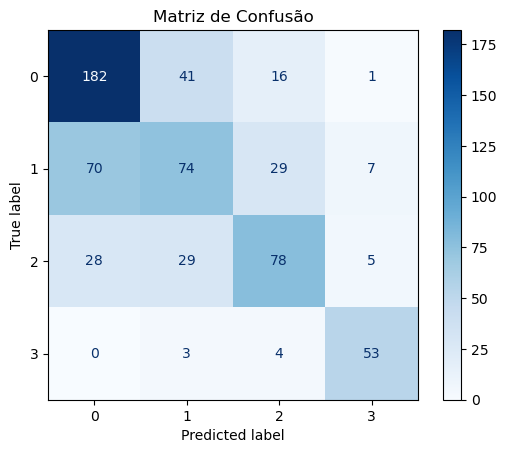

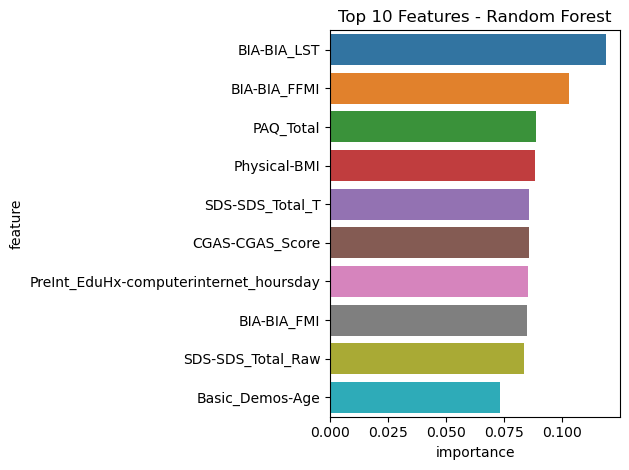

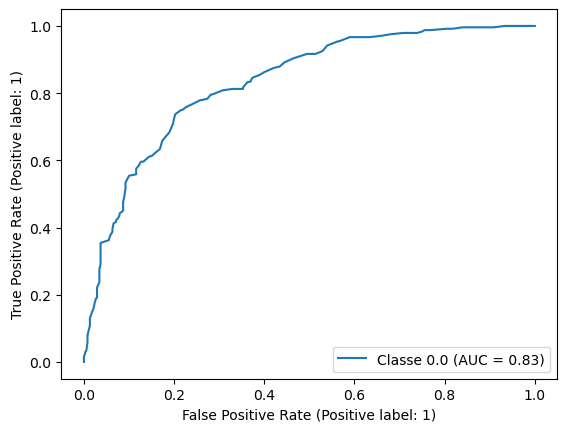

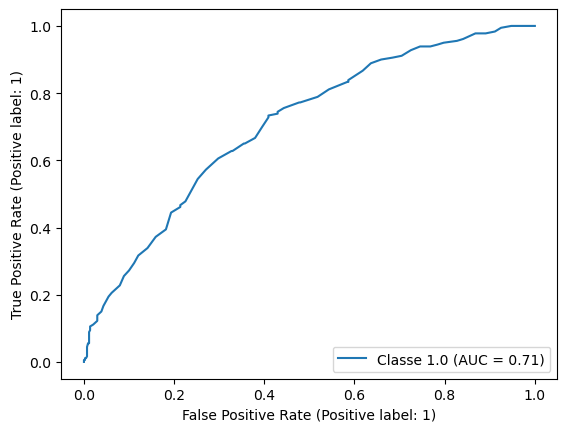

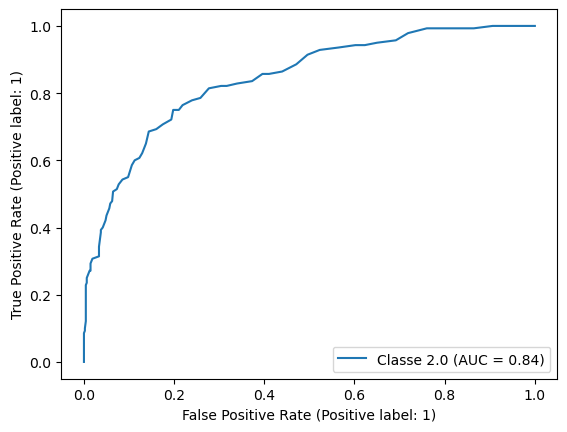

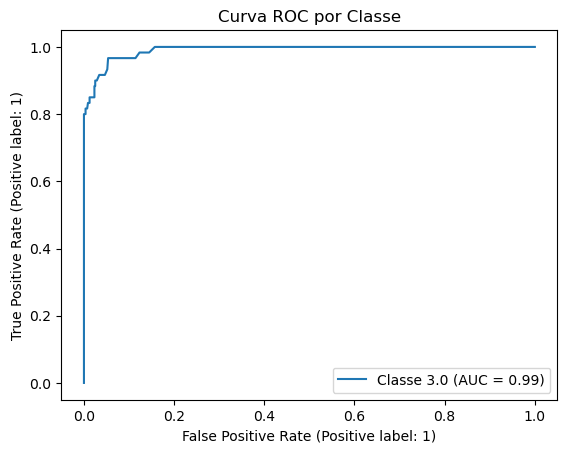

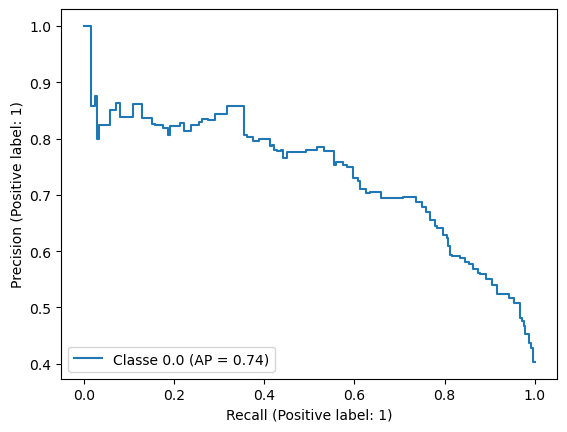

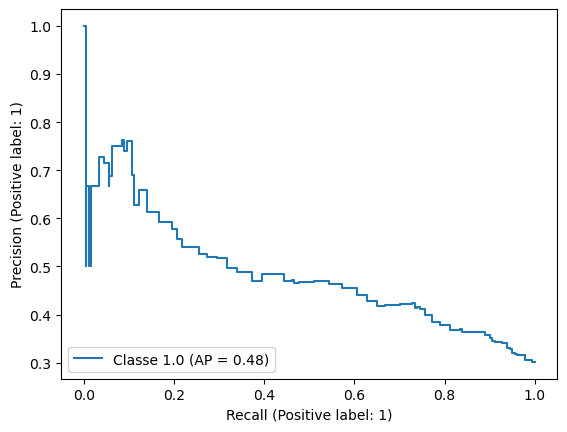

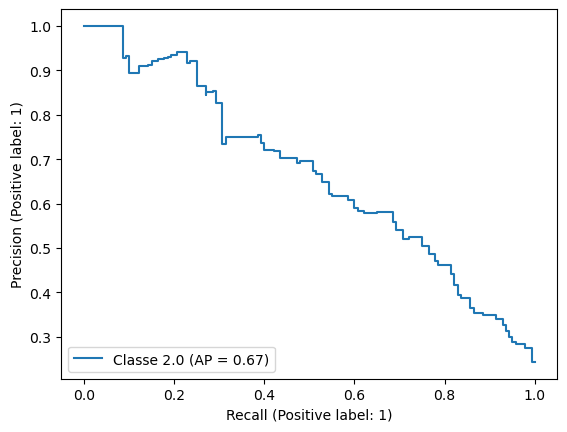

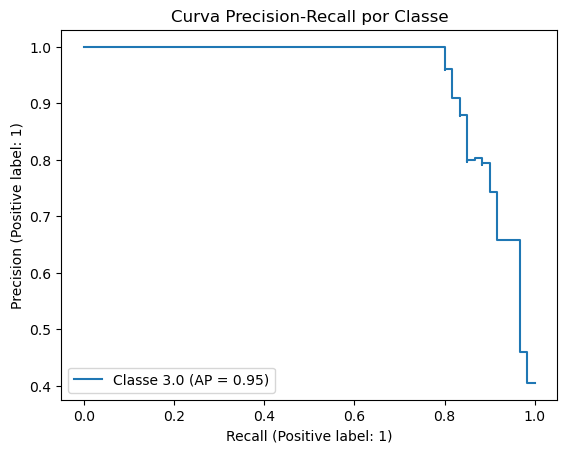

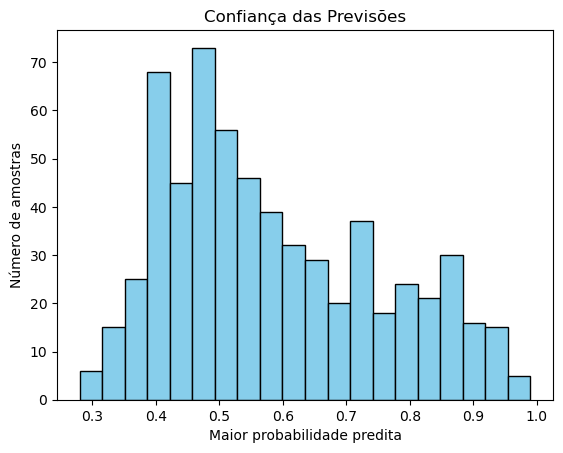

(0.6241935483870967,
 0.6426512229802444,
 0.6524801587301587,
 0.6445347231425986)

In [82]:
X_train, X_test, y_train, y_test = preprocess_dataframe(df_train, 'sii')
modeloRandomForestClassifier(X_train, X_test, y_train, y_test, print_details=True)